In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [3]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))*1/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final, final.diagonal() + x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [4]:
def hr_dots(current, _, b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z - (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack([dots[i] for i in range(3)])

In [5]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [6]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [7]:
def plot_beginning_and_end(y, start, end, p=0.99, legend=False, title=True, channel=0):
    l = y.shape[0]
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
    for i in range(start, end):
        ax1.plot(y[:int(p*l), channel, i], label=i)
        ax1.grid(True)
        ax1.set_xlim([0, int(p*l)])
        ax2.plot(y[int((1 - p)*l):, channel, i], label=i)
        ax2.grid(True)
        ax2.set_xlim()
    if legend:
        ax1.legend(loc="lower left")
    if title:
        plt.suptitle(f"First and last {100*p}% of neurons {start} - {end}")

In [8]:
def plot_state_diagram(x):
    plt.plot(x[1:], x[:-1], "o")

In [9]:
n = np.loadtxt("connectomes/cat_connectome")/3
cortex_mask = np.zeros_like(n)
cortex_mask[:18, :18] = 1
cortex_mask[18:28, 18:28] = 2
cortex_mask[28:45, 28:45] = 3
cortex_mask[45:, 45:] = 4
G1 = n.copy()
G1[cortex_mask == 0] = 0
G2 = n.copy()
G2[cortex_mask != 0] = 0

In [10]:
# For validation
for i in [1, 2, 3, 4]:
    print(i, cortex_size(cortex_mask, i))

1 18
2 10
3 17
4 20


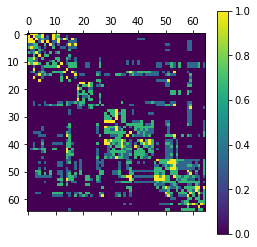

In [11]:
plt.matshow(n)
plt.colorbar()

In [12]:
b = 3.2                           # Controls spiking frequency
i0 = 4.4*np.ones(n.shape[0])      # Input current ---- It's an array so we can add noise later
x_rev = 2                         # Reverse potential
λ = 10                            # Sigmoidal function parameter
θ = -0.25                         # Sigmoidal function parameter
μ = 0.01                          # Time scale of slow current
s = 4.0                           # Governs adaptation (whatever that means)
x_rest = -1.6                     # Resting potential
α = 0.210                         # Intra connection strength ---- VARIED PARAMETER
n1 = np.count_nonzero(G1, axis=1) # Number of intra connections from a given neuron
n1[n1 == 0] = 1                   # This is to remove a divide-by-zero; if n1 is 0, then so is G1
β = 0.040                         # Inter connection strength ---- VARIED PARAMETER
n2 = np.count_nonzero(G2, axis=1) # Number of inter connections from a given neuron
n2[n2 == 0] = 1                   # This is to remove a divide-by-zero; if n2 is 0, then so is G2

In [13]:
ivs = np.zeros([3, n.shape[0]])   # Initial values [[x], [y], [z]]
ivs[0] = 4*np.random.random(n.shape[0]) - 2
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

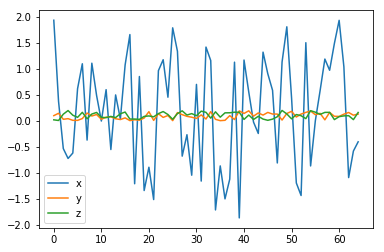

In [14]:
plt.plot(ivs[0], label="x")
plt.plot(ivs[1], label="y")
plt.plot(ivs[2], label="z")
plt.legend()

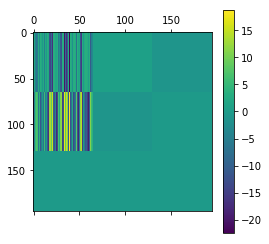

In [15]:
plt.matshow(jac(0, ivs))
plt.colorbar()

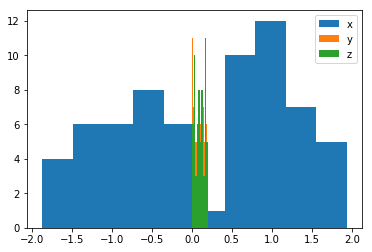

In [16]:
plt.hist(ivs[0], label="x")
plt.hist(ivs[1], label="y")
plt.hist(ivs[2], label="z")
plt.legend()

In [17]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [18]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [19]:
%%time
sol_sync = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                     t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                     max_step=1e-1, dense_output=True, method="RK45")

Wall time: 2min 10s


In [20]:
tmax/len(sol_sync.t)

0.0999900009999

In [21]:
vals_sync = sol_sync.sol(t).T

In [22]:
vals_sync = vals_sync.reshape(-1, 3, 65)

In [23]:
vals_sync.shape

(400000, 3, 65)

(-2.25, 2.25)

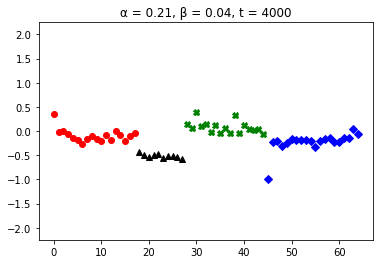

In [24]:
plt.plot(range(18), vals_sync[-1, 0, :18], "ro")
plt.plot(range(18, 28), vals_sync[-1, 0, 18:28], "k^")
plt.plot(range(28, 45), vals_sync[-1, 0, 28:45], "gX")
plt.plot(range(45, 65), vals_sync[-1, 0, 45:], "bD")
plt.title("α = {}, β = {}, t = {}".format(α, β, tmax))
plt.ylim([-2.25, 2.25])

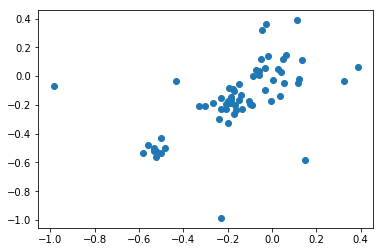

In [25]:
plot_state_diagram(vals_sync[-1, 0, :])

In [47]:
p = 0.01

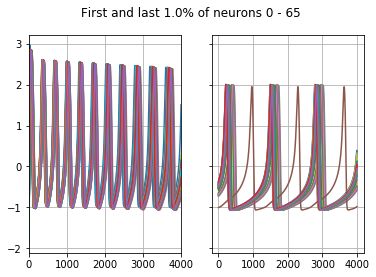

In [48]:
plot_beginning_and_end(vals_sync, 0, 65, p=p)

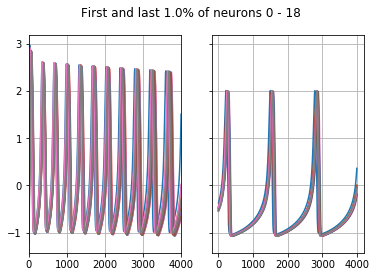

In [49]:
plot_beginning_and_end(vals_sync, 0, 18, p=p)

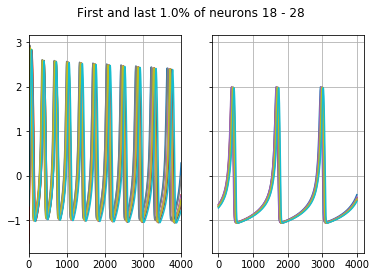

In [50]:
plot_beginning_and_end(vals_sync, 18, 28, p=p)

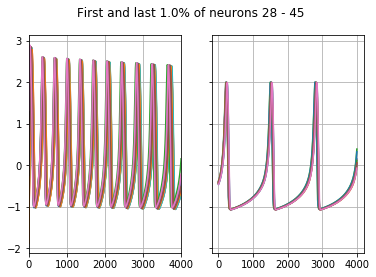

In [51]:
plot_beginning_and_end(vals_sync, 28, 45, p=p)

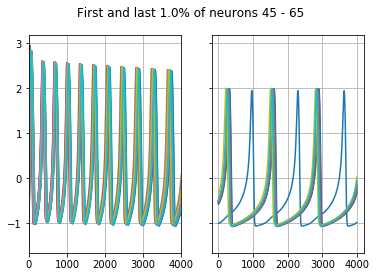

In [52]:
plot_beginning_and_end(vals_sync, 45, 65, p=p)

In [32]:
α = 0.001
β = 0.001

In [33]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [34]:
%%time
sol_async = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                      t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                      max_step=1e-1, dense_output=True, method="RK45")

Wall time: 2min 30s


In [35]:
tmax/len(sol_async.t)

0.0999900009999

In [36]:
vals_async = sol_async.sol(t).T

In [37]:
vals_async = vals_async.reshape(-1, 3, 65)

In [38]:
vals_async.shape

(400000, 3, 65)

(-2.25, 2.25)

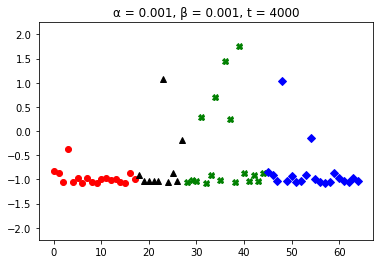

In [39]:
plt.plot(range(18), vals_async[-1, 0, :18], "ro")
plt.plot(range(18, 28), vals_async[-1, 0, 18:28], "k^")
plt.plot(range(28, 45), vals_async[-1, 0, 28:45], "gX")
plt.plot(range(45, 65), vals_async[-1, 0, 45:], "bD")
plt.title("α = {}, β = {}, t = {}".format(α, β, tmax))
plt.ylim([-2.25, 2.25])

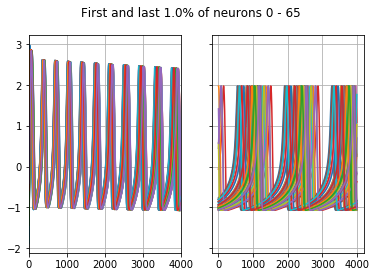

In [53]:
plot_beginning_and_end(vals_async, 0, 65, legend=False, p=p)

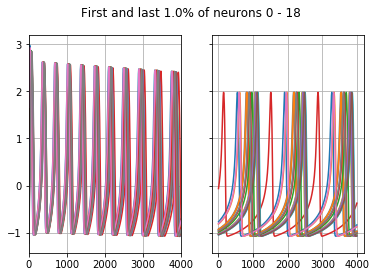

In [54]:
plot_beginning_and_end(vals_async, 0, 18, p=p)

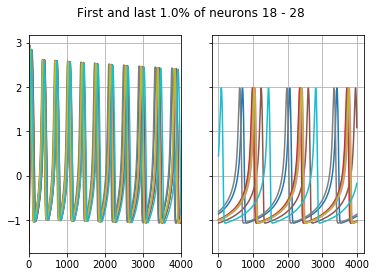

In [55]:
plot_beginning_and_end(vals_async, 18, 28, p=p)

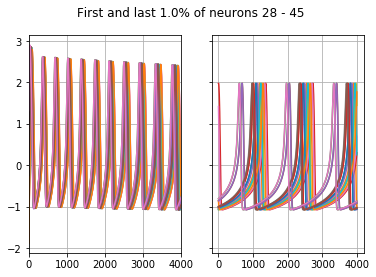

In [56]:
plot_beginning_and_end(vals_async, 28, 45, p=p)

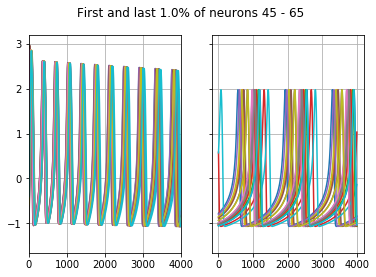

In [57]:
plot_beginning_and_end(vals_async, 45, 65, p=p)